In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from helpers import (
    get_binary_repr,
    get_compact_repr,
    plot_bin_vs_compact,
    plot_storage_saved_for_each_encoding,
    print_data_for_k,
)

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
def generate_sequences(
    possible_chars: list, mean_length: int, std_length: int, num_sequences: int
):
    data = np.array(
        [
            np.random.choice(
                possible_chars,
                size=np.random.randint(
                    mean_length - std_length, mean_length + std_length
                ),
                replace=True,
            )
            for _ in range(num_sequences)
        ],
        dtype=object,
    )
    return data

In [3]:
# generate 1000 random DNA sequences of length 100 +- 50, each with a random length
CONFIG = {
    "possible_chars": ["A", "C", "G", "T"],
    "mean_length": 100,
    "std_length": 50,
    "num_sequences": 1000,
}

data = generate_sequences(**CONFIG)

In [4]:
# %%timeit
df = pd.DataFrame(data, columns=["seq"])

df["bin_repr"] = df["seq"].parallel_map(get_binary_repr)
df["comp_repr"] = df["seq"].parallel_map(get_compact_repr)

# merge sequence
df["merged_bin"] = df["bin_repr"].parallel_apply(lambda x: "".join([str(i) for i in x]))
df["merged_comp"] = df["comp_repr"].parallel_apply(
    lambda x: "".join([str(i) for i in x])
)

df["bin_len"] = df["bin_repr"].parallel_apply(len)
df["comp_len"] = df["comp_repr"].parallel_apply(len)

df["diff"] = df["bin_len"] - df["comp_len"]

df.drop(columns=["seq", "bin_repr", "comp_repr"], inplace=True)

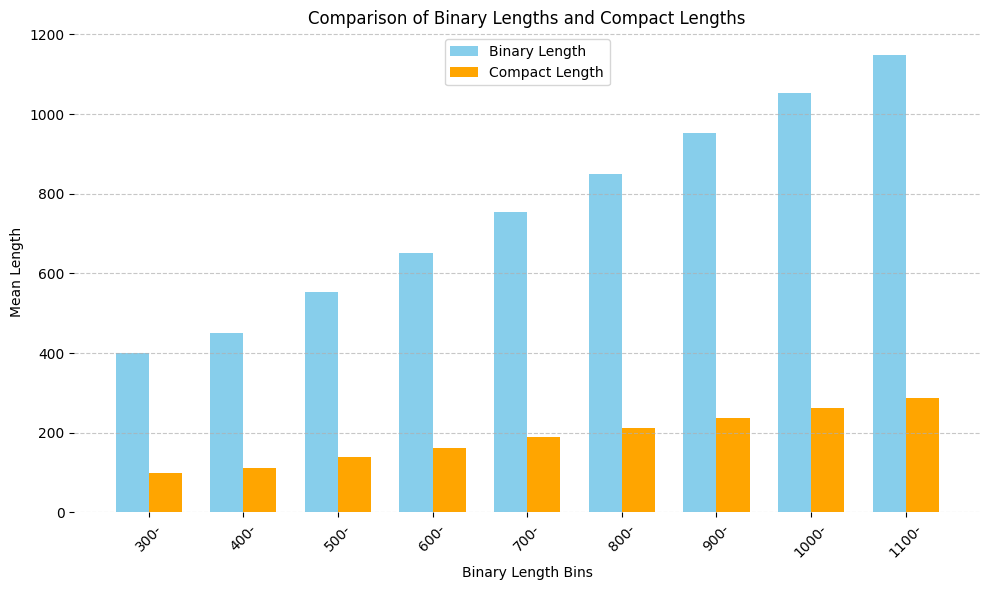

In [5]:
plot_bin_vs_compact(df)

In [6]:
storage_data_bin = df["bin_len"].sum()
storage_data_comp = df["comp_len"].sum()

print(f"Total storage for binary representation: {storage_data_bin} bits")
print(f"Total storage for compact representation: {storage_data_comp} bits")
print(f"Storage saved: {storage_data_bin - storage_data_comp} bits")
print(
    f"Storage saved (%): {100 * (storage_data_bin - storage_data_comp) / storage_data_bin:.2f}%"
)

Total storage for binary representation: 782408 bits
Total storage for compact representation: 195602 bits
Storage saved: 586806 bits
Storage saved (%): 75.00%


Given that $n$ represents the bit-level size of any character in UTF8, $k$ represents the number of unique letters that could be used, then we can represent the percentage of storage space saved as $\eta$.

$$
    \eta (k, n) = \frac{n}{ \lceil \log_2 (k) \rceil }
$$

And for our comparison, we have $k=4$, $n=8$, so $\eta$ could be represented by:
$$
    \eta (4, 8) = \frac{8}{ \lceil \log_2 (4) \rceil } = \frac{8}{4} = 4
$$

The value $\eta=4$ represents a 4x reduction in storage, in other terms, the saved storage space is defined as $\Delta$, where $\Delta$ is represented by the following equation.

$$
    \Delta = \frac{\eta - 1}{\eta}
$$

And for our case with $\eta$ being equal to $4$, $\Delta$ becomes:

$$
    \Delta = \frac{4 - 1}{4} = 75\%
$$

In [7]:
print_data_for_k(4)
print_data_for_k(25)
print_data_for_k(28)
print_data_for_k(64)

Storage saved for k=4, which is the number of possible characters for a DNA/RNA sequence
If the encoding was ASCII	with k=4, storage saved: 71.43%
If the encoding was UTF-8	with k=4, storage saved: 75.00%
If the encoding was UTF-16	with k=4, storage saved: 87.50%
If the encoding was UTF-32	with k=4, storage saved: 93.75%

Storage saved for k=25, which is the number of possible characters for a DNA/RNA sequence
If the encoding was ASCII	with k=25, storage saved: 28.57%
If the encoding was UTF-8	with k=25, storage saved: 37.50%
If the encoding was UTF-16	with k=25, storage saved: 68.75%
If the encoding was UTF-32	with k=25, storage saved: 84.38%

Storage saved for k=28, which is the number of possible characters for a DNA/RNA sequence
If the encoding was ASCII	with k=28, storage saved: 28.57%
If the encoding was UTF-8	with k=28, storage saved: 37.50%
If the encoding was UTF-16	with k=28, storage saved: 68.75%
If the encoding was UTF-32	with k=28, storage saved: 84.38%

Storage saved for 

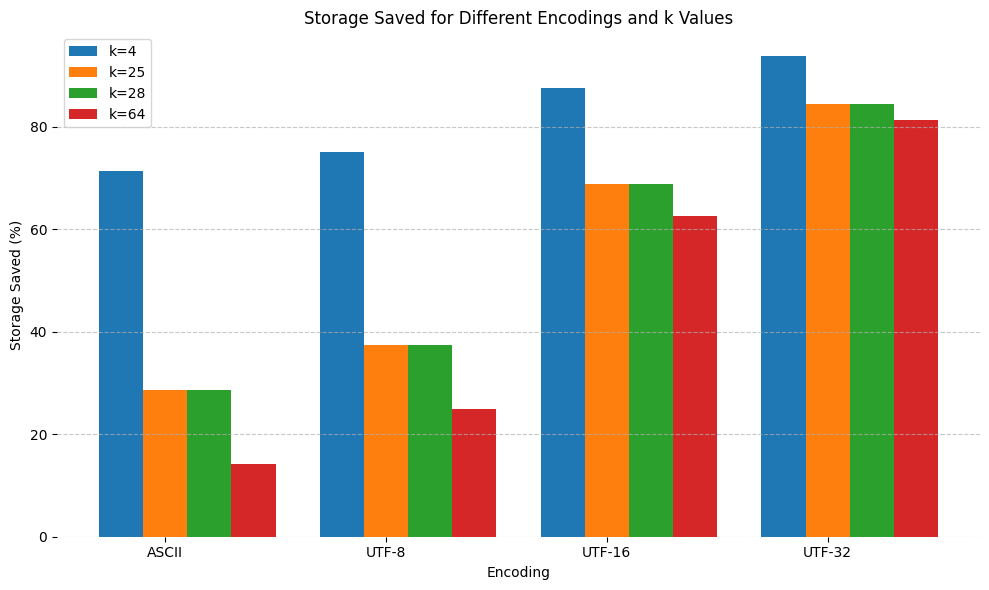

In [8]:
plot_storage_saved_for_each_encoding()

From the previous plot, we can notice that the larger the encoding originally is, the better our method saves space. We can see that the highest amounts of storage saved is absolutely needed when the encoding is UTF-32 because the usage of $32$ bits representing a staggering $2^{32}$ unique characters while we only need $4$ for DNA or RNA sequences, and $25$ for protein sequences. For different values of $k$ ranging between similar outputs in the $\lceil \log_2(x) \rceil$ region, the reduction is similar, this is because the number of bits is equal. Although this wouldn't be the case if we used another space efficient compact representation like canonical codes (e.g. Huffman) which can reduce that even more (but not significantly more unless the value of $k$ is slightly higher than the boundary). For example, the reduction when $k=2^{10} + 1$ is not similar to the reduction when $k=2^{11} - 1$. In our method the region from $2^{10}$ to $2^{11}-1$ results in the same storage reduction because we use a blind compression technique. Other techniques mentioned like canonical codes can perform slightly better in these regions, but this part is left for future work.